In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
np.random.seed(42)

## GENERATING LORENZ ATTRACTOR DATA WITH RUNGE KUTTA 4 ##

In [17]:
def lorenz_system(state, t=0):
    """
    Lorenz system differential equations.
    
    Parameters:
    -----------
    state : array-like
        Current position in 3D space [x, y, z]
    t : float
        Time (not used in autonomous system)
    
    Returns:
    --------
    array : Velocity vector [dx/dt, dy/dt, dz/dt]
    """
    x, y, z = state
    
    # Lorenz parameters that produce butterfly pattern
    sigma = 10.0
    rho = 28.0
    beta = 8.0/3.0
    
    # Lorenz equations 
    dx_dt = sigma * (y - x)
    dy_dt = x * (rho - z) - y
    dz_dt = x * y - beta * z
    
    return np.array([dx_dt, dy_dt, dz_dt]) #Velocity Vector that tells us which direction to move next 

def runge_kutta_4(f, y0, t_span, dt):
    """
    4th order Runge-Kutta integration method for autonomous systems.
    
    Parameters:
    -----------
    f : function
        Differential equation function f(y, t)
    y0 : array
        Initial conditions
    t_span : tuple
        (start_time, end_time)
    dt : float
        Time step
    
    Returns:
    --------
    t : array
        Time points
    y : array
        Solution trajectory
    """
    t_start, t_end = t_span
    t = np.arange(t_start, t_end, dt)
    n_steps = len(t)
    n_vars = len(y0)
    
    # Initialize solution array
    y = np.zeros((n_steps, n_vars))
    y[0] = y0
    
    # RK4 integration loop
    for i in range(n_steps - 1):
        k1 = dt * f(y[i], t[i])
        k2 = dt * f(y[i] + k1/2, t[i] + dt/2)
        k3 = dt * f(y[i] + k2/2, t[i] + dt/2)
        k4 = dt * f(y[i] + k3, t[i] + dt)
        
        y[i+1] = y[i] + (k1 + 2*k2 + 2*k3 + k4) / 6
    
    return t, y

def runge_kutta_adapted(f, y0, t_span, dt, args):
    """
    Adapted 4th order Runge-Kutta for systems with additional parameters.
    This is specifically designed for reservoir dynamics during listening stage.
    
    Parameters:
    -----------
    f : function
        Differential equation function f(y, t, *args)
    y0 : array
        Initial conditions (reservoir state)
    t_span : tuple
        (start_time, end_time) - usually just one time step
    dt : float
        Time step
    args : tuple
        Additional arguments (u_current, M, gamma, input_strength, W_in)
    
    Returns:
    --------
    y : array
        Updated state after one integration step
    """
    t_start, t_end = t_span
    
    # For single time step integration
    y = y0.copy()
    t = t_start
    
    # Single RK4 step
    k1 = dt * f(y, t, *args)
    k2 = dt * f(y + k1/2, t + dt/2, *args)
    k3 = dt * f(y + k2/2, t + dt/2, *args)
    k4 = dt * f(y + k3, t + dt, *args)
    
    y_new = y + (k1 + 2*k2 + 2*k3 + k4) / 6
    
    return y_new

def reservoir_dynamics(r, t, u_current, M, gamma, input_strength, W_in):
    """
    Reservoir differential equation: dr/dt = γ[-r + tanh(M·r + σ·W_in·u)]
    
    Parameters:
    -----------
    r : array
        Current reservoir state (100D)
    t : float
        Current time (not used but required for RK4 interface)
    u_current : array
        Current input (3D Lorenz state)
    M : array
        Internal connection matrix (100x100)
    gamma : float
        Decay rate parameter
    input_strength : float
        Input scaling factor (sigma)
    W_in : array
        Input connection matrix (100x3)
    
    Returns:
    --------
    dr_dt : array
        Time derivative of reservoir state
    """
    # Compute total activation: internal recurrence + external input
    activation = np.dot(M, r) + input_strength * np.dot(W_in, u_current)
    
    # Apply reservoir dynamics equation
    dr_dt = gamma * (-r + np.tanh(activation))
    
    return dr_dt


In [22]:
class ReservoirComputer:
    """
    Reservoir Computer implementation for time series prediction.
    Based on the continuous-time formulation from Flynn's thesis.
    Uses RK4 integration for both Lorenz generation and reservoir dynamics.
    """
    
    def __init__(self, N=100, D=3, spectral_radius=0.6, sparsity=0.05, 
                 input_strength=0.2, gamma=10, beta=1e-4):
        """
        Initialize the Reservoir Computer.
        
        Parameters:
        -----------
        N : int
            Number of neurons in reservoir
        D : int  
            Input dimension (3 for Lorenz system)
        spectral_radius : float
            Spectral radius (ρ) of internal connection matrix
        sparsity : float
            Sparsity (P) of connections in reservoir
        input_strength : float
            Input scaling factor (σ)
        gamma : float
            Decay rate parameter (γ)
        beta : float
            Ridge regression regularization parameter
        """
        self.N = N
        self.D = D
        self.spectral_radius = spectral_radius
        self.sparsity = sparsity
        self.input_strength = input_strength
        self.gamma = gamma
        self.beta = beta
        self._initialize_matrices()

    def _initialize_matrices(self):
        """
        Initialize the adjacency matrix M and input matrix W_in.
        Following Erdős-Rényi topology as described in the thesis.
        """
        # Create adjacency matrix M with Erdős-Rényi topology
        # Each element has probability 'sparsity' of being non-zero
        M = np.random.rand(self.N, self.N)
        M = (M < self.sparsity).astype(float)
        
        # Replace non-zero elements with random values from (-1, 1)
        non_zero_mask = M != 0 
        M[non_zero_mask] = np.random.uniform(-1, 1, np.sum(non_zero_mask))
        
        # Scale matrix to desired spectral radius
        eigenvalues = np.linalg.eigvals(M)
        current_spectral_radius = np.max(np.abs(eigenvalues))
        
        if current_spectral_radius != 0:
            M = M * (self.spectral_radius / current_spectral_radius)
        
        self.M = M
        
        # Create input matrix W_in (N x D)
        # Each row has only one non-zero element (sparse input connections)
        self.W_in = np.zeros((self.N, self.D))
        for i in range(self.N):
            # Randomly choose which input dimension connects to this neuron
            j = np.random.randint(0, self.D)
            # Random weight from (-1, 1)
            self.W_in[i, j] = np.random.uniform(-1, 1)
            
        print(f"Initialized reservoir with spectral radius: {self.spectral_radius}")
        print(f"Sparsity of M: {np.mean(M != 0):.3f}")
        
    def listening_stage(self, u, dt, t_listen):
        """
        Implements the listening stage using RK4 integration.
        The reservoir is driven by input u(t) and learns to represent the dynamics.
        
        This is where generalized synchronization occurs between the Lorenz system
        and the reservoir dynamics.
        
        Parameters:
        -----------
        u : array
            Input signal of shape (n_timesteps, D) - the Lorenz trajectory
        dt : float
            Integration time step (0.01 seconds)
        t_listen : float
            Duration of listening stage (100 seconds)
        
        Returns:
        --------
        r : array
            Reservoir states during entire simulation (70000, 100)
        """
        n_total = u.shape[0]
        
        # Initialize reservoir state - all neurons start at zero
        # This represents the initial condition r(0) = 0 from the thesis
        r = np.zeros((n_total, self.N))
        
        print(f"Starting listening stage with {n_total} time steps...")
        print(f"Each integration step uses RK4 with dt = {dt}")
        
        # Integrate reservoir dynamics using RK4 for each time step
        for i in range(1, n_total):
            # Current Lorenz input (3D state at time step i-1)
            u_current = u[i-1]
            
            # Prepare arguments for reservoir dynamics function
            args = (u_current, self.M, self.gamma, self.input_strength, self.W_in)
            
            # Use RK4 to integrate reservoir dynamics for one time step
            # This solves: dr/dt = γ[-r + tanh(M·r + σ·W_in·u)] over interval [t, t+dt]
            r[i] = runge_kutta_adapted(
                reservoir_dynamics,    # The differential equation function
                r[i-1],               # Current reservoir state (100D)
                (0, dt),              # Time span for this single step
                dt,                   # Time step
                args                  # Additional parameters
            )
            
            # Print progress every 1000 steps (10 seconds of simulation)
            if i % 1000 == 0:
                print(f"  Processed {i/100:.1f} seconds, max reservoir activity: {np.max(np.abs(r[i])):.3f}")
        
        print(f"Listening stage completed. Final reservoir state shape: {r.shape}")
        return r

    def train(self, r, u, t_listen, t_train, dt):
        """
        Train the readout matrix using ridge regression with squaring technique.
        This learns the transformation from high-dimensional reservoir space
        back to the 3D Lorenz space.
        
        Parameters:
        -----------
        r : array
            Reservoir states from listening stage (70000, 100)
        u : array
            Target output signal - original Lorenz data (70000, 3)
        t_listen : float
            Duration of listening stage (100 seconds)
        t_train : float
            Total duration including training (200 seconds)
        dt : float
            Time step (0.01 seconds)
        
        Returns:
        --------
        W_out : array
            Trained readout matrix (3, 200)
        """
        # Convert times to indices
        i_listen = int(t_listen / dt)     # 10000 - start of training data
        i_train = int(t_train / dt)       # 20000 - end of training data
        
        print(f"Training phase: using data from t={t_listen}s to t={t_train}s")
        print(f"Training indices: {i_listen} to {i_train} (total: {i_train - i_listen} points)")
        
        # Extract training data (from end of listening to end of training)
        r_train = r[i_listen:i_train]     # Shape: (10000, 100)
        u_train = u[i_listen:i_train]     # Shape: (10000, 3)
        
        print(f"Training data shapes - Reservoir: {r_train.shape}, Target: {u_train.shape}")
        
        # Implement squaring technique: q(r) = [r; r²]
        # This breaks symmetry and improves performance (see thesis Section 2.3.2)
        r_squared = r_train ** 2          # Element-wise squaring
        q_r = np.hstack([r_train, r_squared])  # Shape: (10000, 200)
        
        print(f"After squaring technique: q(r) shape = {q_r.shape}")
        
        # Prepare matrices for ridge regression
        # Following Equation (2.16): W_out = Y·X^T·(X·X^T + βI)^(-1)
        X = q_r.T  # Response data matrix (200 x 10000)
        Y = u_train.T  # Target data matrix (3 x 10000)
        
        print(f"Ridge regression matrices - X: {X.shape}, Y: {Y.shape}")
        
        # Compute X·X^T (200 x 200 matrix)
        XX_T = np.dot(X, X.T)
        
        # Add regularization term β·I to prevent overfitting
        I = np.eye(2 * self.N)            # 200 x 200 identity matrix
        XX_T_reg = XX_T + self.beta * I   # Regularized matrix
        
        print(f"Regularization parameter β = {self.beta}")
        print(f"Computing matrix inverse of {XX_T_reg.shape} matrix...")
        
        # Compute readout matrix using ridge regression formula
        W_out = np.dot(np.dot(Y, X.T), np.linalg.inv(XX_T_reg))
        
        self.W_out = W_out
        
        # Split W_out into linear and square parts for analysis
        self.W_out_linear = W_out[:, :self.N]      # Linear terms (3 x 100)
        self.W_out_square = W_out[:, self.N:]      # Square terms (3 x 100)
        
        print(f"Training completed!")
        print(f"W_out shape: {W_out.shape}")
        print(f"W_out_linear shape: {self.W_out_linear.shape}")
        print(f"W_out_square shape: {self.W_out_square.shape}")
        
        return W_out

    def predict(self, r_initial, n_predict, dt):
        """
        Autonomous prediction stage - the closed-loop RC.
        Uses RK4 integration for reservoir dynamics during prediction.
        
        The reservoir now operates autonomously, feeding its own predictions
        back as input: dr/dt = γ[-r + tanh(M·r + σ·W_in·W_out·q(r))]
        
        Parameters:
        -----------
        r_initial : array
            Initial reservoir state from end of training (100D)
        n_predict : int
            Number of prediction steps (10000 for 100 seconds)
        dt : float
            Time step (0.01 seconds)
        
        Returns:
        --------
        predictions : array
            Predicted Lorenz trajectories (10000, 3)
        r_predict : array
            Reservoir states during prediction (10000, 100)
        """
        print(f"Starting prediction phase for {n_predict} steps ({n_predict*dt:.1f} seconds)")
        
        # Initialize arrays
        r_predict = np.zeros((n_predict, self.N))
        predictions = np.zeros((n_predict, self.D))
        
        # Set initial state from end of training
        r_predict[0] = r_initial.copy()
        
        # Compute initial prediction using readout
        q_r = np.hstack([r_initial, r_initial**2])  # Apply squaring technique
        predictions[0] = np.dot(self.W_out, q_r)    # First prediction
        
        print(f"Initial prediction: {predictions[0]}")
        print(f"Starting autonomous prediction loop...")
        
        # Autonomous prediction loop using RK4 integration
        for i in range(1, n_predict):
            # Previous prediction becomes the input (closed-loop feedback)
            u_pred = predictions[i-1]
            
            # Prepare arguments for reservoir dynamics with predicted input
            args = (u_pred, self.M, self.gamma, self.input_strength, self.W_in)
            
            # Integrate reservoir dynamics using RK4
            r_predict[i] = runge_kutta_adapted(
                reservoir_dynamics,
                r_predict[i-1],
                (0, dt),
                dt,
                args
            )
            
            # Compute new prediction using trained readout matrix
            q_r = np.hstack([r_predict[i], r_predict[i]**2])
            predictions[i] = np.dot(self.W_out, q_r)
            
            # Print progress every 1000 steps
            if i % 1000 == 0:
                print(f"  Prediction at t={i*dt:.1f}s: {predictions[i]}")
        
        print(f"Prediction completed! Generated {n_predict} time points")
        return predictions, r_predict
    

STEP 1: GENERATING LORENZ ATTRACTOR DATA
Time step: 0.01 seconds
Total time: 700 seconds
Initial condition: [1.0, 1.0, 1.0]
Expected data points: 70000
✓ Generated 70000 time points
✓ Lorenz data shape: (70000, 3)
✓ Data range - X: [-18.69, 19.56]
✓ Data range - Y: [-25.46, 27.18]
✓ Data range - Z: [0.96, 47.83]

STEP 2: INITIALIZING RESERVOIR COMPUTER
Initialized reservoir with spectral radius: 0.9
Sparsity of M: 0.049

Time allocation:
  Listening stage: 0 to 100 seconds
  Training stage: 100 to 500 seconds
  Prediction stage: 100 seconds autonomous

STEP 3A: LISTENING STAGE - LEARNING LORENZ DYNAMICS
Starting listening stage with 70000 time steps...
Each integration step uses RK4 with dt = 0.01
  Processed 10.0 seconds, max reservoir activity: 1.000
  Processed 20.0 seconds, max reservoir activity: 1.000
  Processed 30.0 seconds, max reservoir activity: 1.000
  Processed 40.0 seconds, max reservoir activity: 0.996
  Processed 50.0 seconds, max reservoir activity: 1.000
  Processed 6

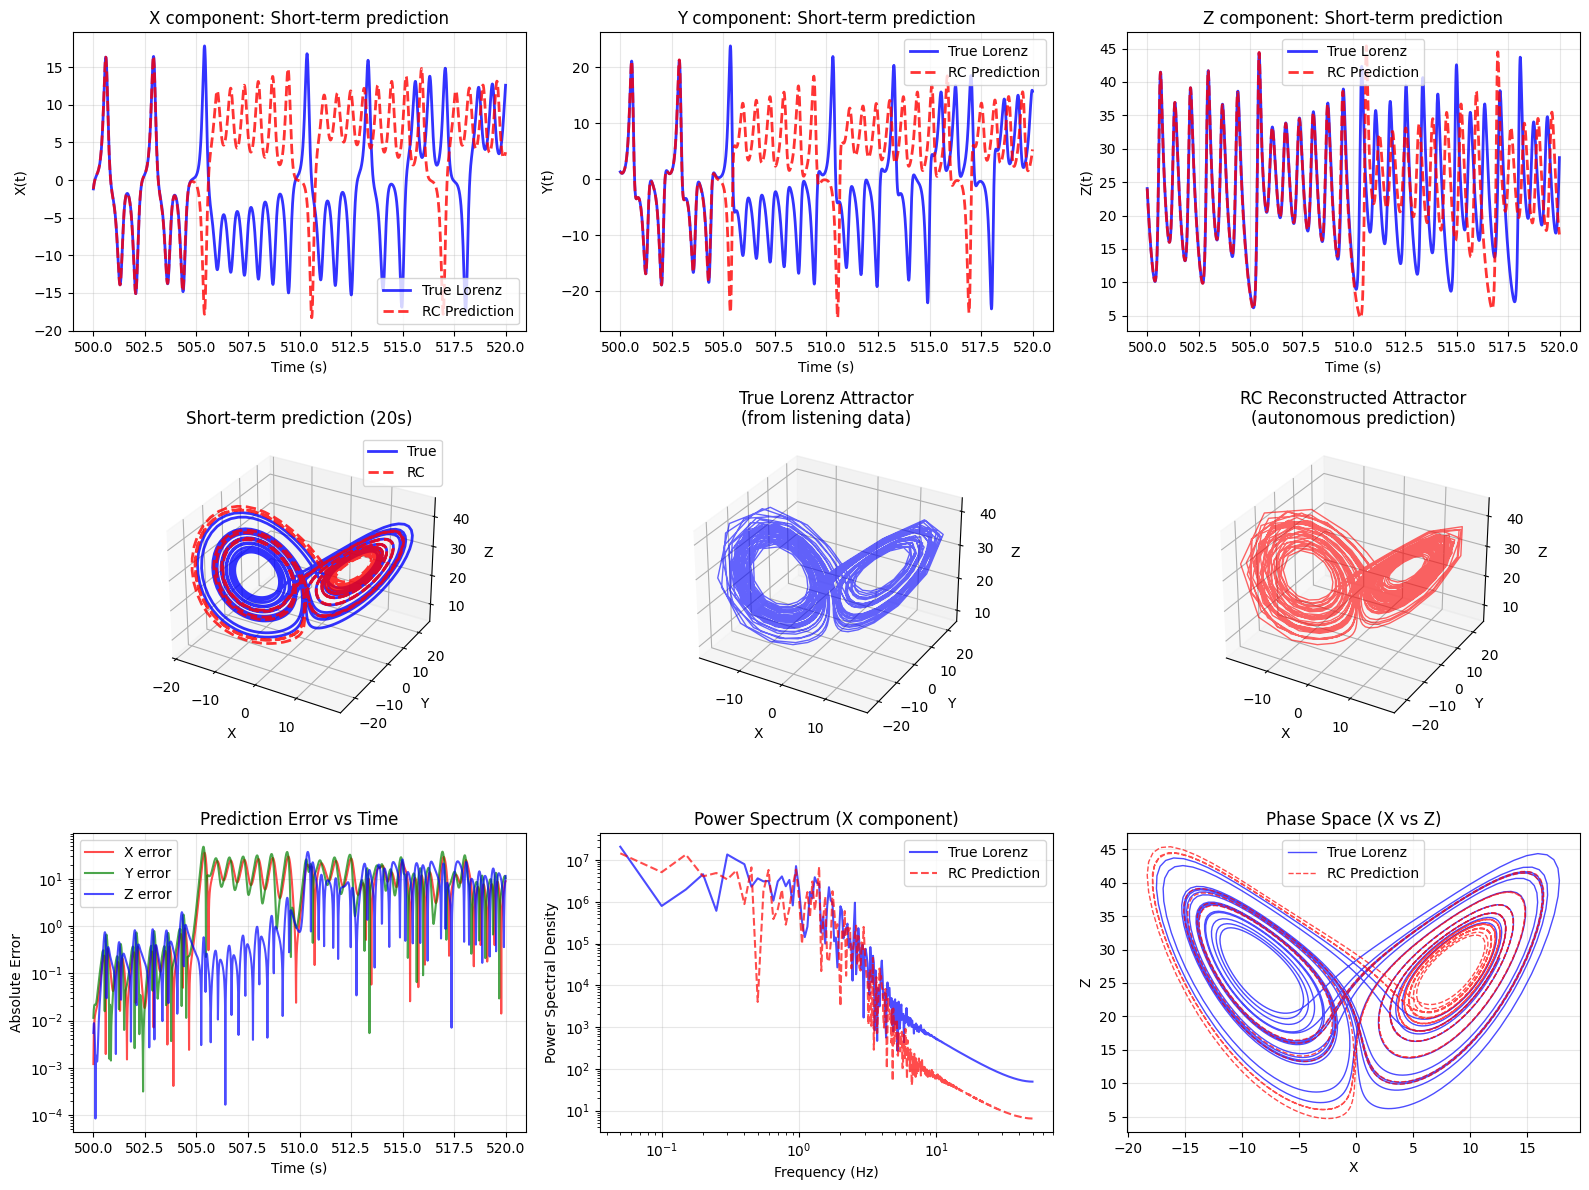


Prediction Quality Metrics:
  Mean absolute error (first 20.0s): 7.8582
  Max absolute error: 47.7140
  RMS error: 11.4565


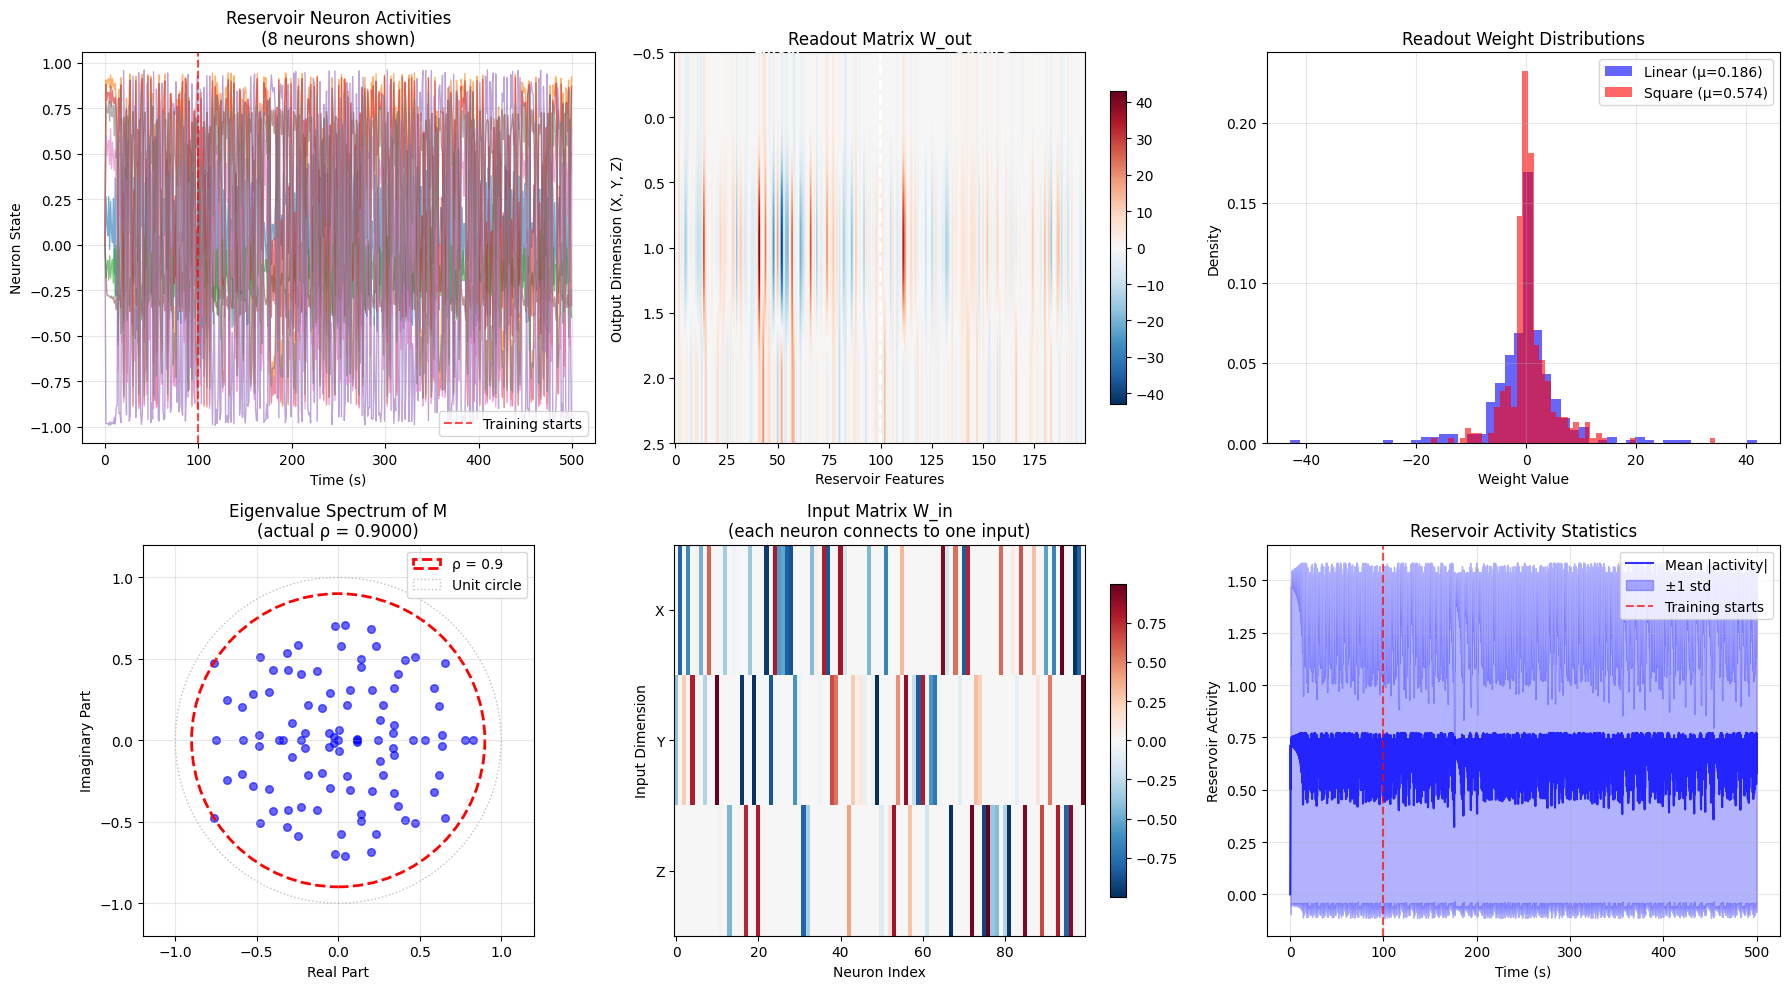


Detailed Reservoir Statistics:
Network Architecture:
  - Reservoir size (N): 100
  - Input dimension (D): 3
  - Target spectral radius: 0.9
  - Actual spectral radius: 0.900000
  - Connection sparsity: 0.049
  - Non-zero connections: 485

Hyperparameters:
  - Input strength (σ): 0.2
  - Decay rate (γ): 10
  - Regularization (β): 0.001

Readout Matrix Analysis:
  - Linear weights - mean: 0.186137, std: 7.242468
  - Square weights - mean: 0.573925, std: 4.564945
  - Linear/Square weight ratio: 1.587

Reservoir Dynamics:
  - Final reservoir state mean: 0.030248
  - Final reservoir state std: 0.652616
  - Max reservoir activity: 0.999992
  - Effective reservoir dimension: 100

RESERVOIR COMPUTING PIPELINE COMPLETED SUCCESSFULLY!


In [24]:
def main():    
    # ========================================================================
    # STEP 1: GENERATE LORENZ ATTRACTOR DATA USING RK4
    # ========================================================================
    
    # Time parameters matching the thesis methodology
    dt = 0.01              # Integration time step (10 milliseconds)
    t_total = 700          # Total simulation time (700 seconds)
    initial_condition = [1.0, 1.0, 1.0]  # Standard Lorenz initial condition
    
    print("=" * 70)
    print("STEP 1: GENERATING LORENZ ATTRACTOR DATA")
    print("=" * 70)
    print(f"Time step: {dt} seconds")
    print(f"Total time: {t_total} seconds") 
    print(f"Initial condition: {initial_condition}")
    print(f"Expected data points: {int(t_total/dt)}")
    
    # Generate Lorenz data using RK4 integration
    t, lorenz_data = runge_kutta_4(lorenz_system, initial_condition, (0, t_total), dt)
    
    print(f"✓ Generated {len(t)} time points")
    print(f"✓ Lorenz data shape: {lorenz_data.shape}")
    print(f"✓ Data range - X: [{np.min(lorenz_data[:,0]):.2f}, {np.max(lorenz_data[:,0]):.2f}]")
    print(f"✓ Data range - Y: [{np.min(lorenz_data[:,1]):.2f}, {np.max(lorenz_data[:,1]):.2f}]")
    print(f"✓ Data range - Z: [{np.min(lorenz_data[:,2]):.2f}, {np.max(lorenz_data[:,2]):.2f}]")
    
    # ========================================================================
    # STEP 2: CREATE AND INITIALIZE RESERVOIR COMPUTER
    # ========================================================================
    
    print("\n" + "=" * 70)
    print("STEP 2: INITIALIZING RESERVOIR COMPUTER")
    print("=" * 70)
    
    # Create reservoir with thesis parameters
    rc = ReservoirComputer(
        N=100,                # Number of reservoir neurons
        D=3,                  # Lorenz system dimension
        spectral_radius=0.9,  # ρ (rho) - controls memory and stability
        sparsity=0.05,        # P - connection probability (5%)
        input_strength=0.2,   # σ (sigma) - input scaling
        gamma=10,             # γ (gamma) - reservoir time scale
        beta=1e-3           # β (beta) - regularization strength
    )
    
    # ========================================================================
    # STEP 3: THREE-PHASE LEARNING PROCESS
    # ========================================================================
    
    # Define the three phases of reservoir computing
    t_listen = 100   # Listening stage: 100 seconds
    t_train = 200    # Training stage: 100-200 seconds (total 200s)
    t_predict = 100  # Prediction stage: 100 seconds
    
    print(f"\nTime allocation:")
    print(f"  Listening stage: 0 to {t_listen} seconds")
    print(f"  Training stage: {t_listen} to {t_train} seconds")
    print(f"  Prediction stage: {t_predict} seconds autonomous")
    
    # Phase 1: Listening Stage - Generalized Synchronization
    print("\n" + "=" * 70)
    print("STEP 3A: LISTENING STAGE - LEARNING LORENZ DYNAMICS")
    print("=" * 70)
    
    r_states = rc.listening_stage(lorenz_data, dt, t_listen)
    
    # Phase 2: Training Stage - Learning the Readout
    print("\n" + "=" * 70)
    print("STEP 3B: TRAINING STAGE - LEARNING THE READOUT")
    print("=" * 70)
    
    W_out = rc.train(r_states, lorenz_data, t_listen, t_train, dt)
    
    # Phase 3: Prediction Stage - Autonomous Generation
    print("\n" + "=" * 70)
    print("STEP 3C: PREDICTION STAGE - AUTONOMOUS GENERATION")
    print("=" * 70)
    
    i_train = int(t_train / dt)
    r_initial = r_states[i_train].copy()
    n_predict = int(t_predict / dt)
    
    print(f"Starting prediction from reservoir state at t={t_train}s")
    print(f"Initial reservoir state stats: mean={np.mean(r_initial):.4f}, std={np.std(r_initial):.4f}")
    
    predictions, r_predict = rc.predict(r_initial, n_predict, dt)
    
    # ========================================================================
    # STEP 4: ANALYSIS AND VISUALIZATION
    # ========================================================================
    
    print("\n" + "=" * 70)
    print("STEP 4: ANALYSIS AND VISUALIZATION")
    print("=" * 70)
    
    visualize_results(t, lorenz_data, predictions, rc, dt, t_train, t_predict)
    analyze_reservoir(rc, r_states, i_train)
    
    print("\n" + "=" * 70)
    print("RESERVOIR COMPUTING PIPELINE COMPLETED SUCCESSFULLY!")
    print("=" * 70)
    
    return rc, lorenz_data, predictions

def visualize_results(t, lorenz_data, predictions, rc, dt, t_train, t_predict):
    """Visualize the results of reservoir computing with detailed analysis."""
    
    fig = plt.figure(figsize=(16, 12))
    
    # Time indices for plotting
    i_start = int(t_train / dt)
    i_end = i_start + min(int(20 / dt), len(predictions))  # Show 20 seconds
    
    # Create time arrays
    time_true = t[i_start:i_end]
    time_pred = np.arange(len(time_true)) * dt + t_train
    
    # Plot time series comparison for each Lorenz component
    for i, (label, color) in enumerate([('X', 'red'), ('Y', 'green'), ('Z', 'blue')]):
        plt.subplot(3, 3, i+1)
        plt.plot(time_true, lorenz_data[i_start:i_end, i], 'b-', 
                 label='True Lorenz', linewidth=2, alpha=0.8)
        plt.plot(time_pred, predictions[:len(time_true), i], 'r--', 
                 label='RC Prediction', linewidth=2, alpha=0.8)
        plt.xlabel('Time (s)')
        plt.ylabel(f'{label}(t)')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.title(f'{label} component: Short-term prediction')
    
    # 3D phase space comparison - short term
    ax1 = fig.add_subplot(3, 3, 4, projection='3d')
    ax1.plot(lorenz_data[i_start:i_end, 0], 
             lorenz_data[i_start:i_end, 1], 
             lorenz_data[i_start:i_end, 2], 'b-', linewidth=2, label='True', alpha=0.8)
    ax1.plot(predictions[:len(time_true), 0], 
             predictions[:len(time_true), 1], 
             predictions[:len(time_true), 2], 'r--', linewidth=2, label='RC', alpha=0.8)
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1.set_zlabel('Z')
    ax1.set_title('Short-term prediction (20s)')
    ax1.legend()
    
    # Long-term attractor reconstruction comparison
    ax2 = fig.add_subplot(3, 3, 5, projection='3d')
    sample_true = lorenz_data[int(50/dt):int(100/dt):5]  # Sample from listening period
    ax2.plot(sample_true[:, 0], sample_true[:, 1], sample_true[:, 2], 
             'b-', alpha=0.6, linewidth=1)
    ax2.set_xlabel('X')
    ax2.set_ylabel('Y') 
    ax2.set_zlabel('Z')
    ax2.set_title('True Lorenz Attractor\n(from listening data)')
    
    ax3 = fig.add_subplot(3, 3, 6, projection='3d')
    # Use middle portion of predictions for long-term behavior
    start_idx = max(int(30/dt), 0) if len(predictions) > int(30/dt) else 0
    sample_pred = predictions[start_idx::5]
    ax3.plot(sample_pred[:, 0], sample_pred[:, 1], sample_pred[:, 2], 
             'r-', alpha=0.6, linewidth=1)
    ax3.set_xlabel('X')
    ax3.set_ylabel('Y')
    ax3.set_zlabel('Z')
    ax3.set_title('RC Reconstructed Attractor\n(autonomous prediction)')
    
    # Error analysis over time
    plt.subplot(3, 3, 7)
    min_len = min(len(time_true), len(predictions))
    error = np.abs(predictions[:min_len] - lorenz_data[i_start:i_start+min_len])
    plt.plot(time_pred[:min_len], error[:, 0], 'r-', label='X error', alpha=0.7)
    plt.plot(time_pred[:min_len], error[:, 1], 'g-', label='Y error', alpha=0.7)
    plt.plot(time_pred[:min_len], error[:, 2], 'b-', label='Z error', alpha=0.7)
    plt.xlabel('Time (s)')
    plt.ylabel('Absolute Error')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.title('Prediction Error vs Time')
    plt.yscale('log')
    
    # Power spectrum comparison
    plt.subplot(3, 3, 8)
    # Compute power spectra
    freq_true = np.fft.fftfreq(len(time_true), dt)
    freq_pred = np.fft.fftfreq(min_len, dt)
    
    psd_true = np.abs(np.fft.fft(lorenz_data[i_start:i_end, 0]))**2
    psd_pred = np.abs(np.fft.fft(predictions[:min_len, 0]))**2
    
    plt.loglog(freq_true[1:len(freq_true)//2], psd_true[1:len(psd_true)//2], 
               'b-', label='True Lorenz', alpha=0.7)
    plt.loglog(freq_pred[1:len(freq_pred)//2], psd_pred[1:len(psd_pred)//2], 
               'r--', label='RC Prediction', alpha=0.7)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power Spectral Density')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.title('Power Spectrum (X component)')
    
    # Phase space trajectory comparison
    plt.subplot(3, 3, 9)
    plt.plot(lorenz_data[i_start:i_end, 0], lorenz_data[i_start:i_end, 2], 
             'b-', label='True Lorenz', linewidth=1, alpha=0.7)
    plt.plot(predictions[:len(time_true), 0], predictions[:len(time_true), 2], 
             'r--', label='RC Prediction', linewidth=1, alpha=0.7)
    plt.xlabel('X')
    plt.ylabel('Z')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.title('Phase Space (X vs Z)')
    
    plt.tight_layout()
    plt.show()
    
    # Calculate and display error statistics
    prediction_error = np.mean(np.abs(predictions[:min_len] - 
                                      lorenz_data[i_start:i_start+min_len]))
    print(f"\nPrediction Quality Metrics:")
    print(f"  Mean absolute error (first {min_len*dt:.1f}s): {prediction_error:.4f}")
    print(f"  Max absolute error: {np.max(error):.4f}")
    print(f"  RMS error: {np.sqrt(np.mean(error**2)):.4f}")

def analyze_reservoir(rc, r_states, i_train):
    """Analyze the internal dynamics and structure of the reservoir."""
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    
    # 1. Reservoir neuron activities during different phases
    ax = axes[0, 0]
    time_points = np.arange(0, i_train, 100) * 0.01  # Every 100 steps = 1 second
    for i in range(min(8, rc.N)):
        ax.plot(time_points, r_states[:i_train:100, i], alpha=0.6, linewidth=1)
    ax.axvline(x=100, color='red', linestyle='--', alpha=0.7, label='Training starts')
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Neuron State')
    ax.set_title('Reservoir Neuron Activities\n(8 neurons shown)')
    ax.grid(True, alpha=0.3)
    ax.legend()
    
    # 2. Readout matrix visualization
    ax = axes[0, 1]
    im = ax.imshow(rc.W_out, aspect='auto', cmap='RdBu_r', vmin=-np.max(np.abs(rc.W_out)), 
                   vmax=np.max(np.abs(rc.W_out)))
    ax.set_xlabel('Reservoir Features')
    ax.set_ylabel('Output Dimension (X, Y, Z)')
    ax.set_title('Readout Matrix W_out')
    ax.axvline(x=rc.N-0.5, color='white', linestyle='--', linewidth=2)
    ax.text(rc.N/2, -0.5, 'Linear', ha='center', color='white', weight='bold')
    ax.text(rc.N*1.5, -0.5, 'Square', ha='center', color='white', weight='bold')
    plt.colorbar(im, ax=ax, shrink=0.8)
    
    # 3. Weight distributions comparison
    ax = axes[0, 2]
    ax.hist(rc.W_out_linear.flatten(), bins=50, alpha=0.6, 
            label=f'Linear (μ={np.mean(rc.W_out_linear):.3f})', density=True, color='blue')
    ax.hist(rc.W_out_square.flatten(), bins=50, alpha=0.6, 
            label=f'Square (μ={np.mean(rc.W_out_square):.3f})', density=True, color='red')
    ax.set_xlabel('Weight Value')
    ax.set_ylabel('Density')
    ax.set_title('Readout Weight Distributions')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # 4. Eigenvalue spectrum of internal matrix M
    ax = axes[1, 0]
    eigenvalues = np.linalg.eigvals(rc.M)
    ax.scatter(eigenvalues.real, eigenvalues.imag, alpha=0.6, s=30, c='blue')
    
    # Draw spectral radius circle
    circle = plt.Circle((0, 0), rc.spectral_radius, fill=False, color='red', 
                       linewidth=2, linestyle='--', label=f'ρ = {rc.spectral_radius}')
    ax.add_patch(circle)
    
    # Draw unit circle for reference
    unit_circle = plt.Circle((0, 0), 1.0, fill=False, color='gray', 
                            linewidth=1, linestyle=':', alpha=0.5, label='Unit circle')
    ax.add_patch(unit_circle)
    
    ax.set_xlabel('Real Part')
    ax.set_ylabel('Imaginary Part')
    ax.set_title(f'Eigenvalue Spectrum of M\n(actual ρ = {np.max(np.abs(eigenvalues)):.4f})')
    ax.grid(True, alpha=0.3)
    ax.set_aspect('equal')
    ax.set_xlim(-1.2, 1.2)
    ax.set_ylim(-1.2, 1.2)
    ax.legend()
    
    # 5. Input matrix W_in structure
    ax = axes[1, 1]
    im = ax.imshow(rc.W_in.T, aspect='auto', cmap='RdBu_r')
    ax.set_xlabel('Neuron Index')
    ax.set_ylabel('Input Dimension')
    ax.set_yticks([0, 1, 2])
    ax.set_yticklabels(['X', 'Y', 'Z'])
    ax.set_title('Input Matrix W_in\n(each neuron connects to one input)')
    plt.colorbar(im, ax=ax, shrink=0.8)
    
    # 6. Reservoir activity statistics over time
    ax = axes[1, 2]
    activity_mean = np.mean(np.abs(r_states[:i_train]), axis=1)
    activity_std = np.std(r_states[:i_train], axis=1)
    time_full = np.arange(i_train) * 0.01
    
    ax.plot(time_full, activity_mean, 'b-', label='Mean |activity|', alpha=0.8)
    ax.fill_between(time_full, activity_mean - activity_std, activity_mean + activity_std, 
                    alpha=0.3, color='blue', label='±1 std')
    ax.axvline(x=100, color='red', linestyle='--', alpha=0.7, label='Training starts')
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Reservoir Activity')
    ax.set_title('Reservoir Activity Statistics')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print comprehensive statistics
    print(f"\nDetailed Reservoir Statistics:")
    print(f"{'='*50}")
    print(f"Network Architecture:")
    print(f"  - Reservoir size (N): {rc.N}")
    print(f"  - Input dimension (D): {rc.D}")
    print(f"  - Target spectral radius: {rc.spectral_radius}")
    print(f"  - Actual spectral radius: {np.max(np.abs(eigenvalues)):.6f}")
    print(f"  - Connection sparsity: {np.mean(rc.M != 0):.3f}")
    print(f"  - Non-zero connections: {np.sum(rc.M != 0)}")
    
    print(f"\nHyperparameters:")
    print(f"  - Input strength (σ): {rc.input_strength}")
    print(f"  - Decay rate (γ): {rc.gamma}")
    print(f"  - Regularization (β): {rc.beta}")
    
    print(f"\nReadout Matrix Analysis:")
    print(f"  - Linear weights - mean: {np.mean(rc.W_out_linear):.6f}, std: {np.std(rc.W_out_linear):.6f}")
    print(f"  - Square weights - mean: {np.mean(rc.W_out_square):.6f}, std: {np.std(rc.W_out_square):.6f}")
    print(f"  - Linear/Square weight ratio: {np.std(rc.W_out_linear)/np.std(rc.W_out_square):.3f}")
    
    print(f"\nReservoir Dynamics:")
    print(f"  - Final reservoir state mean: {np.mean(r_states[i_train]):.6f}")
    print(f"  - Final reservoir state std: {np.std(r_states[i_train]):.6f}")
    print(f"  - Max reservoir activity: {np.max(np.abs(r_states[:i_train])):.6f}")
    print(f"  - Effective reservoir dimension: {np.linalg.matrix_rank(r_states[:i_train].T)}")

if __name__ == "__main__":
    rc, lorenz_data, predictions = main()